### Libraries

In [962]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import ndimage

import shapely.geometry as geom
import pandas as pd
import geopandas as gpd

import math
import time
import pickle
from collections import namedtuple


%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)

## Load from disk

In [963]:
poses = pickle.load(open("poses.df", 'rb'))
arena_d = pickle.load(open("arena_d.df", 'rb'))
arena_g = pickle.load(open("arena_g.gdf", 'rb'))

# Convert Pandas DataFrame to NumPy array
poses_np = np.array(poses.values)

## Variables

In [964]:
Measurement = namedtuple('Measurement', ['sonar', 'IR_L', 'IR_R'])
Motion = namedtuple('Motion', ['distance', 'angle'])
Pose = namedtuple("Pose", ['x', 'y', 'theta'])

## Parameters

In [990]:
SENSORS_VARIANCE = {
    'sonar': 0.1,
    'IR_L' : 0.4,
    'IR_R' : 0.4
}

# THOSE HAVE TO MATCH EXACTLY PARAM IN MAP
RESOLUTION_POS = 0.1
RESOLUTION_ROT = 30

# Further than SENSORS_CUTOFF_STD standard deviations from the mean, 
# we say the sensor readings are improbable for a given pose
SENSORS_CUTOFF_STD = 0.7

CONFIDENCE_SENSORS = 0.6
CONFIDENCE_ODOMETRY = None

## Playground

### Arena

In [991]:
# mock_position = geom.Point(0.01, 0.81)
# # theta = geom.Point(0, 6)
# # mock_circle = geom.Point(0,0).buffer(6, resolution=30)

# # scan = geom.LineString((mock_position, theta))
# # arena_d.loc[len(arena_d)] = ["scan", scan]

# arena_d.loc[len(arena_d)] = ['test', mock_position]
# arena_g = gpd.GeoDataFrame(arena_d)
# arena_g.plot()


# # cleat the dataframe
# arena_d.drop(arena_d.index[arena_d['type'] == 'test'], inplace=True)
# print(arena_g)

### Probability

In [992]:
# sigma = 0.05
# mean = 0.5

# sigma = 1/sigma

# x = np.linspace(0,1,500) # 100 linearly spaced numbers
# y = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((x - mean))**2))

# a = 0.55
# b = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((a - mean))**2))

# plt.plot(x,y)
# plt.plot(a,b,'co')

## Grid Localization

In [993]:
def _match(sensor, reading, lookup_value):
    """
    Determines if a reading from the sensors matches a value 
    in the lookup table with some probability.
    This is useful to find the exact values of 'x' and 'y' as recorded in the lookup table.
    
    """
    SENSORS_CUTOFF_STD = 0.6 
    if reading == None:
        if math.isnan(lookup_value):
            return True
        else:
            return False
    elif sensor == "sonar":
        SIGMA = SENSORS_VARIANCE['sonar']
    elif sensor == "IR_L":
        SIGMA = SENSORS_VARIANCE['IR_L']
    elif sensor == "IR_R":
        SIGMA = SENSORS_VARIANCE['IR_R']

    sigma = 1/SIGMA
    mean = lookup_value
    x = reading
    y = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((x - mean))**2))
    if y > SENSORS_CUTOFF_STD:
        return True
    return False
    
    

def _closest(number, divider):
    """
    Returns the closest number to 'number'
    divisible without remainder by 'divider'.
    """
    
    mod = number % divider        # 28
    
    low = number - mod            # 90
    high = number - mod + divider # 120
    if high - number < number - low:
        return round(high,2)
    else:
        return round(low,2)
    
def localize(poses_np,  measurement):
    """
    poses_np    :: a lookup table of possible poses and sensor readings. Columns: open, x, y, theta, sonar, IR_L, IR_R
    measurement :: a tuple of readings from (sonar, IR_L, IR_R).
    
    """
    
    def move_belief():
        """
        Finds posterior probability, given
            distance traveled in a straight line ('x' and 'y' chnge), OR 
            rotation on the spot.
        Posterior poses_np = [prior] X [probability after motion model]
    
        """
        prob_sum = 0
        
        for i in range(len(poses_np)): # iterate rows
            if poses_np[i][0] == 1: # open space, i.e. not coordinates of an obstacle
                theta = poses_np[i][3]
                
                # determine most likely pose where we were before the movement
                delta_x = math.sin((theta + motion.angle) % 360) * motion.distance
                delta_y = math.cos((theta + motion.angle) % 360) * motion.distance
                
                prev_x = _closest(poses_np[i][1] - delta_x, RESOLUTION_POS)
                prev_y = _closest(poses_np[i][2] - delta_y, RESOLUTION_POS)
                prev_theta = _closest((theta - motion.angle) % 360, RESOLUTION_ROT)
                

                # look up the probability of the previous pose
                print(prev_x, prev_y, prev_theta)

                prev_prob = poses_np[np.where((poses_np[:,1] == prev_x) * (poses_np[:,2] == prev_y) * (poses_np[:,3] == prev_theta) )]
                if prev_prob.shape[0] != 0:
                    prev_prob = prev_prob[0][7]
                    poses_np[i][7] = CONFIDENCE_ODOMETRY * poses_np[i][7] + (1-CONFIDENCE_ODOMETRY) * prev_prob
                    prob_sum += poses_np[i][7]
                    print( poses_np[i][7])
        
        # normalize--> total probability theory
#         for i in range(len(poses_np)):
#             print(prob_sum)
#             poses_np[i][7] = poses_np[i][7] / prob_sum
        
    def sense_belief():
        """
        Finds posterior = [prior] X [probability after measurement]
        
        """
        
        # DEBUGGING VARIABLES
#         count = {
#             'sonar': 0,
#             'IR_L': 0,
#             'IR_R': 0,
#             'all': 0,
#         }
        
        # CRITICAL VARIABLES – 
        # CHANGE ONLY IF YOU KNOW WHAT YOU'RE DOING
        prob_sum = 0
        
        for i in range(len(poses_np)): # iterate rows
            if poses_np[i][0] == 1: # of open space, i.e. not coordinates of an obstacle
                match_all = False
#                 print(str(measurement.IR_R) + " " +  str(poses_np[i][6]))
                if _match('sonar',  measurement.sonar,  poses_np[i][4]):
#                     count['sonar'] += 1
                    if _match('IR_L',  measurement.IR_L,  poses_np[i][5]):
#                         count['IR_L'] += 1
                        if _match('IR_R',  measurement.IR_R,  poses_np[i][6]):
#                             count['IR_R'] += 1
                            match_all = True
                
                poses_np[i][7] = (poses_np[i][7] * (match_all * CONFIDENCE_SENSORS + (1-match_all) * (1.0-CONFIDENCE_SENSORS)))
                prob_sum += poses_np[i][7]
        
        # normalize--> total probability theory
        for i in range(len(poses_np)):
            poses_np[i][7] = poses_np[i][7] / prob_sum
    
    sense_belief()
#     move_belief()
    return poses_np

## Heatmap

In [994]:
def heatmap(poses_np):
    """
    The heatmap relies on the following sorting of the array:
    'y' descending (primary sort)
    'x' ascending (secondary sort)
    'theta' ascending (tertiary sort)
    
    """
    
    plt.rcParams["figure.figsize"] = (10,5)
    heatmap = []
    y = poses_np[0][2]
    row = []
                
    # iterate through lookup table
    for i in range(len(poses_np)): 
        # True while we're moving horizontally to the right – x increases, y stays constant
        if y == poses_np[i][2]:
            if poses_np[i][3] == 0:  # if theta == 0
                row.append(poses_np[i][7]) # append probability
            else:
            # theta is some rotation, we're at same square still
                row[-1] += poses_np[i][7] # saturate probability here 
        # y changes – we're one row lower
        else:
            heatmap.append(row)
            row = []
            y = poses_np[i][2]
            row.append(poses_np[i][7])

    # Make plot with vertical (default) colorbar
    fig, ax = plt.subplots()

    cax = ax.imshow(heatmap, interpolation='nearest', cmap=cm.coolwarm)
    ax.set_title('Probabalistic location')

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
    
    plt.show()

# Run

In [995]:
def refresh(poses_np):
    """ 
    Takes all rows where 0-indexed column 1 one,
    and change 7-indexed column to the prior probability.
    
    """
    prob = 1.0 / len(poses_np[:,0])
    poses_np[poses_np[:, 0] == 1, 7] = prob
    return poses_np

def run(poses_np, measurements):
    for i in range(len(measurements)):
        poses_np = localize(poses_np, measurements[i]) 
        heatmap(poses_np)
    return poses_np

In [996]:
measurements = [Measurement(0.9, 0.012310000, None),
                Measurement(0.8, 0.012310000, None),
                Measurement(0.7, 0.012310000, None),
                Measurement(0.6, 0.012310000, None),
                Measurement(0.5, 0.012310000, None),
                Measurement(0.4, 0.012310000, None),
                Measurement(0.3, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(None, None, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
                Measurement(0.2, 0.012310000, None),
               ]

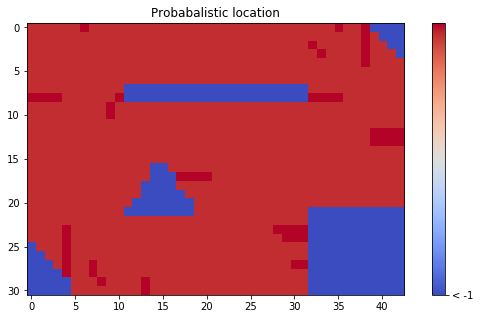

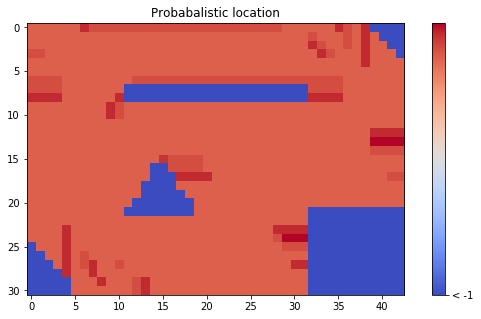

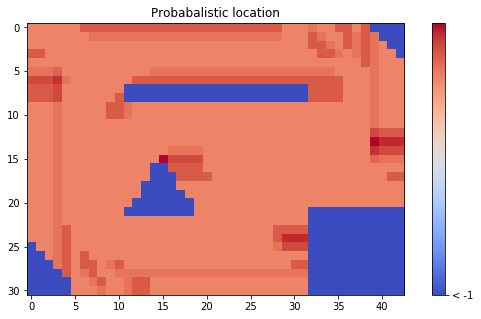

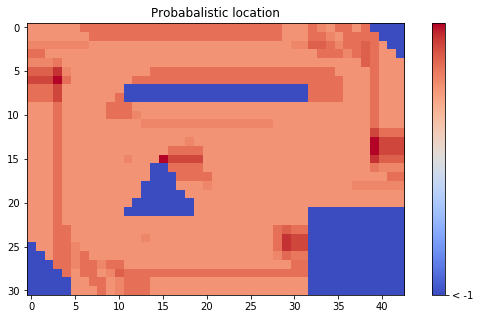

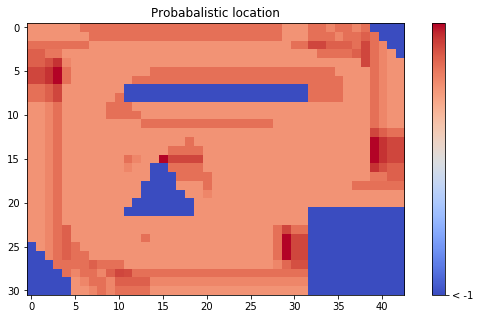

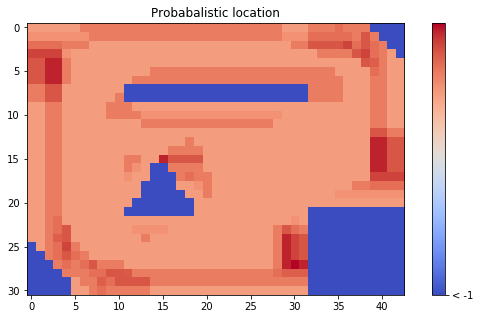

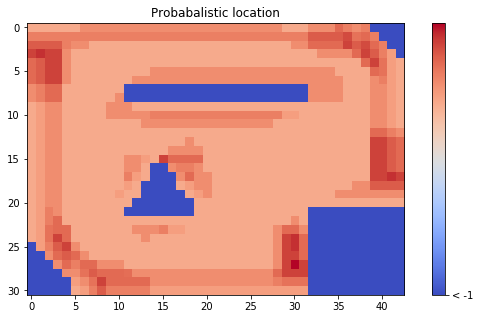

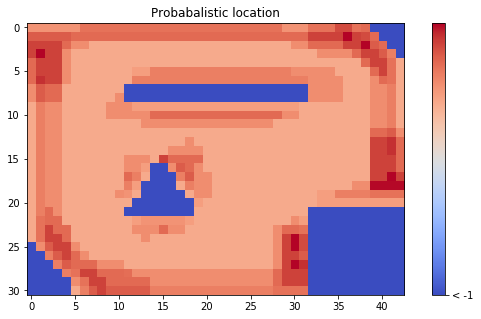

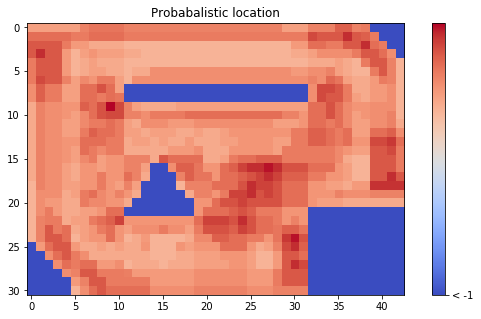

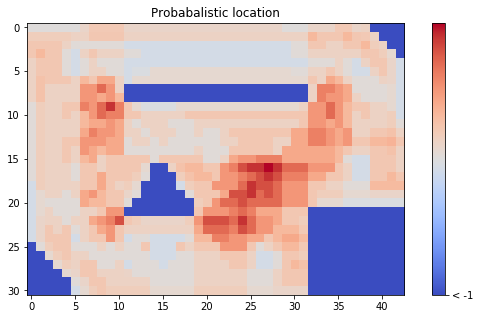

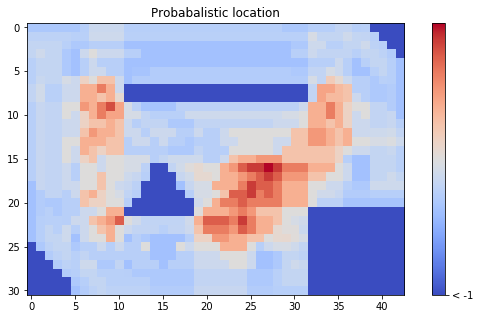

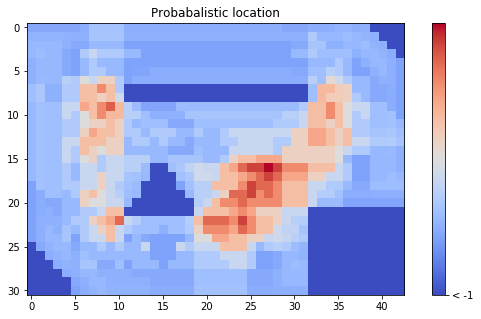

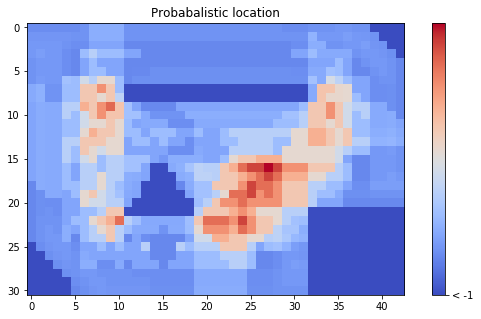

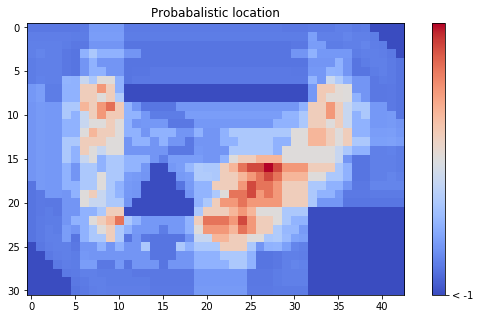

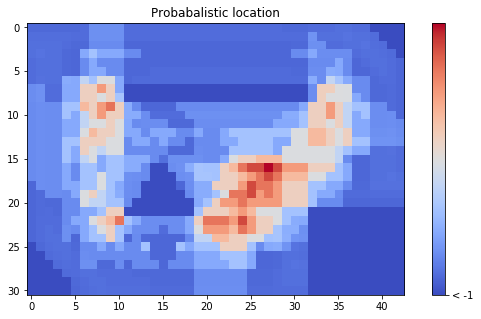

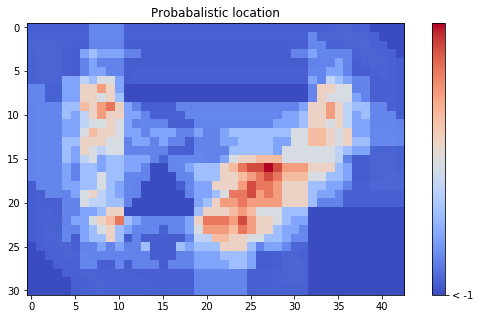

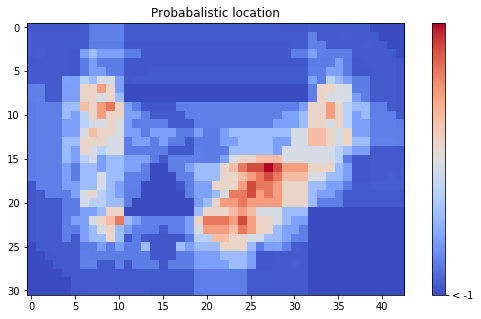

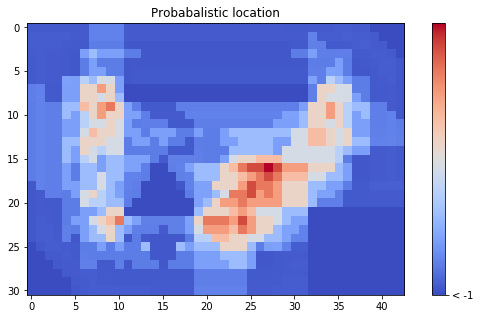

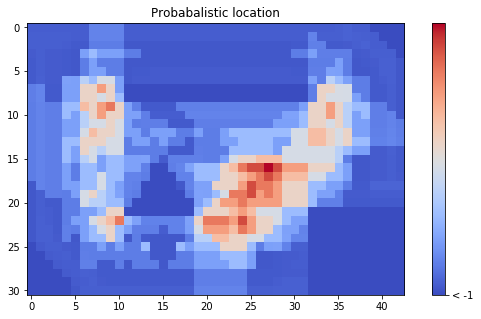

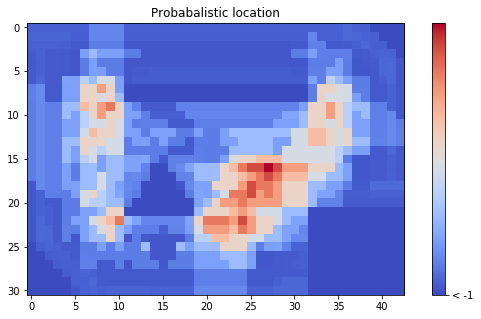

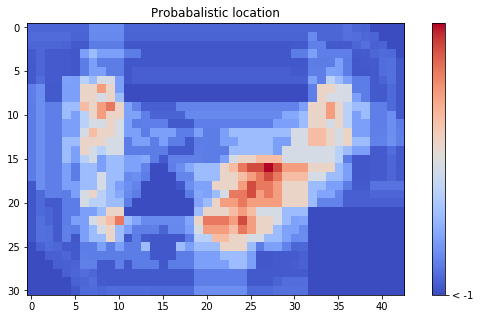

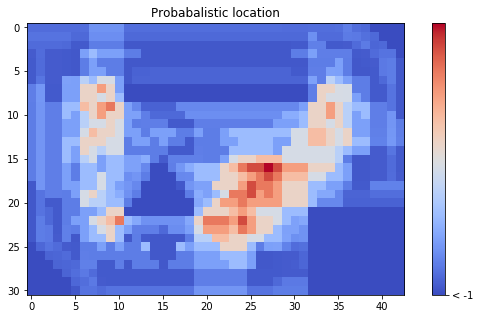

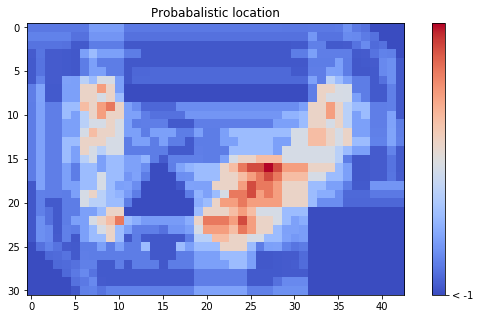

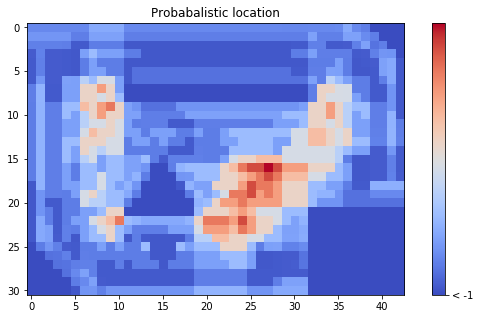

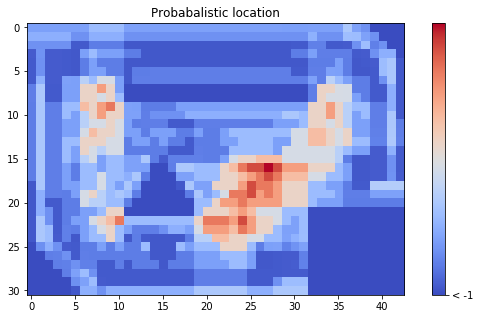

In [997]:
# measurements = [Measurement(0.2, 0.9, None)]
motions      = [Motion(0.1, 0)]

# refresh
poses_np = refresh(poses_np)
# GO!
poses_np = run(poses_np, measurements)

In [987]:
# poses_np[:,7]

In [974]:
# MUST-DOS
# find sensible sigma
# IR adjust for different variance furhter out
# implement IR
# cut off high readings beyond sensor's reach
# maybe change to Log sum? Underflow problem
# plot on heatmat most likely pose + draw lines which show likely orientations

# SIMULATE

# EXTRAS
# plot orientation on the map somehow
# draw most likely location
# posterior() returning a probability? instead of True / False?

In [923]:
poses_np[np.where((poses_np[:,1] == 0.1) * (poses_np[:,2] == 0.1) * (poses_np[:,3] == 0) )].shape

(0, 8)